In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix
from keras.utils import plot_model
import pandas as pd
from keras import Input, Model

In [9]:
# Generate some sample data for the autoencoder
x_train = np.random.rand(1000, 12)
x_test = np.random.rand(100, 12)

In [10]:
input_dim = 12
latent_dim = 3

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            layers.GaussianNoise(1),
            layers.Dense(8, activation='sigmoid',
                        activity_regularizer=regularizers.l2(10e-3)),
            layers.Dense(4, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(input_dim, activation='tanh'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/5


2023-02-17 13:37:32.399193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/250 [============================>.] - ETA: 0s - loss: 0.1674

2023-02-17 13:37:33.775858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: DAGMM/assets
250/250 [==============================] - 2s 8ms/step - loss: 0.1670 - val_loss: 0.1033
Epoch 2/5
250/250 [==============================] - 2s 7ms/step - loss: 0.0975 - val_loss: 0.0923
Epoch 3/5
250/250 [==============================] - 2s 7ms/step - loss: 0.0899 - val_loss: 0.0919
Epoch 4/5
250/250 [==============================] - 1s 4ms/step - loss: 0.0868 - val_loss: 0.0937
Epoch 5/5
250/250 [==============================] - 2s 7ms/step - loss: 0.0850 - val_loss: 0.0916
Model: "autoencoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 4)                 140       
                                                                 
 sequential_9 (Sequential)   (None, 12)                148       
                                                                 
Total params: 288
Trainable params: 288
Non-trai

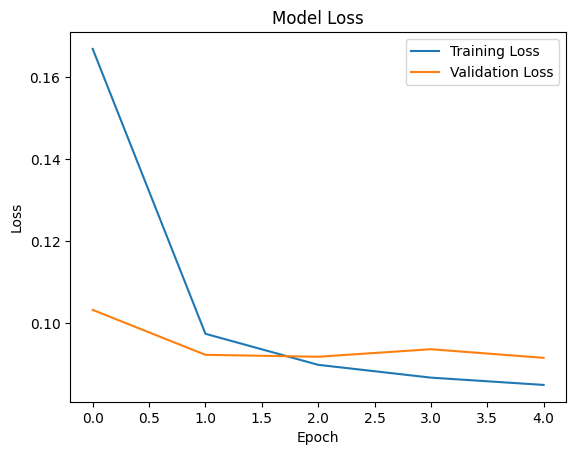

In [11]:
autoencoder = Autoencoder(latent_dim)
callback = EarlyStopping(monitor='val_loss', patience=3)
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
checkpointer = ModelCheckpoint(filepath="DAGMM",
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

batch_size = 4
nb_epochs = 5
history = autoencoder.fit(x_train, x_train,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, tensorboard]).history

autoencoder.summary()

plt.plot(range(nb_epochs), history['loss'], label='Training Loss')
plt.plot(range(nb_epochs), history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Use the trained autoencoder to encode the training data
encoded_data = autoencoder.encoder(x_train).numpy()

# Fit a Gaussian Mixture Model with 2 components to the encoded training data
gmm = GaussianMixture(n_components=2)
gmm.fit(encoded_data)

# Use the GMM to predict the probability densities for the encoded test data
encoded_test_data = autoencoder.encoder(x_test).numpy()
scores = gmm.score_samples(encoded_test_data)

# Identify anomalies based on the GMM probability densities
threshold = np.percentile(scores, 5)
anomalies = x_test[scores < threshold]

Precision: 1.0000, Recall: 1.0000, F1 score: 1.0000


/var/folders/hp/_2zbvh5s43329chnj7b07wm40000gn/T/ipykernel_1655/3354897551.py:13: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * precision * recall / (precision + recall)


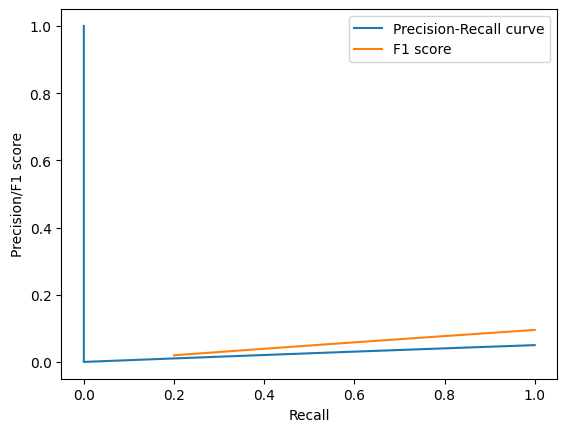

Confusion Matrix:
[[95  0]
 [ 0  5]]


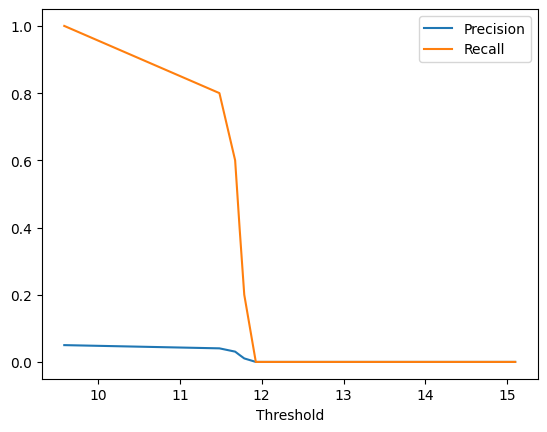

In [14]:
# Calculate precision, recall, and F1 score
y_true = np.zeros_like(scores)
y_true[scores < threshold] = 1
y_pred = np.zeros_like(scores)
y_pred[scores < threshold] = 1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")

# Generate precision-recall curve with F1 score
precision, recall, thresholds = precision_recall_curve(y_true, scores)
f1_scores = 2 * precision * recall / (precision + recall)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(recall, f1_scores, label='F1 score')
plt.xlabel('Recall')
plt.ylabel('Precision/F1 score')
plt.legend()
plt.show()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Generate score with threshold graph
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()
